# Assignment 3.1 - Linear Regression

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf. <br><br>
Please do **NOT** rename the file!

#### State both names of your group members here:
[S M Shameem Ahmed Khan and Rashid Harvey]

---

## Grading Info/Details - Assignment 3.1:

The assignment will be graded semi-automatically, which means that your code will be tested against a set of predefined test cases and qualitatively assessed by a human. This will speed up the grading process for us.

* For passing the test scripts: 
    - Please make sure to **NOT** alter predefined class or function names, as this would lead to failing of the test scripts.
    - Please do **NOT** rename the files before uploading to the Whiteboard!

* **(RESULT)** tags indicate checkpoints that will be specifically assessed by a human.

* You will pass the assignment if you pass the majority of test cases and we can at least confirm effort regarding the **(RESULT)**-tagged checkpoints per task.

---

## Task 3.1.1 - Linear Regression

Linear regression is a supervised learning algorithm that models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data.

### 1. Linear Regression Implementation
* Implement a linear regression model optimized by gradient descent or the closed-form approach presented in the lecture using `numpy` only. Use the `LinearRegression` class structure below. Especially, when using the closed-form, beware of numeric stability issues.**(RESULT)**
* Evaluate the performance of your implementation using appropriate metrics for the [AUTO MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) dataset. Make sure to preprocess the data properly for the regression task. Report on the loss during training the regressor. **(RESULT)**

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# Using gradient descent
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.b0 = 0
        self.b = 0
        self.losses = []
        
    def fit(self, X, y):
        y = y.reshape(-1, 1) # makes the array in one column
        n, p = X.shape
        
        self.b = np.zeros(p)
        self.b0 = 0
        self.losses = []

        for _ in range(self.n_iterations):
            y_pred = X @ self.b + self.b0
            error = y_pred.reshape(-1,1) - y

            dw = (2 / n) * X.T @ error
            db = (2 / n) * np.sum(error)

            self.b -= self.learning_rate * dw.flatten()
            self.b0 -= self.learning_rate * db

            loss = np.mean(error ** 2)
            self.losses.append(loss)
    
    def predict(self, X):
        if None in (self.b0, self.b):
            raise ValueError("First fit, then predict")
        # @ ^= matrix multiplication
        return X @ self.b + self.b0
    
    def mean_squared_error(self, X, Y):
        y_pred = X @ self.b + self.b0
        return np.mean((Y - y_pred) ** 2)

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
    def r2_score(self, X, Y):
        y_pred = X @ self.b + self.b0
        u = np.sum((Y - y_pred) ** 2)
        v = np.sum((Y - np.mean(Y)) ** 2)
        return 1 - u / v

In [39]:
# Get AUTO MPG dataset

# Potentially useful imports
import requests
import zipfile
import pandas as pd
import io

url = "https://archive.ics.uci.edu/static/public/9/auto+mpg.zip"



Linear Regression:
MSE: 11.99781056012773
R2: 0.8025465792408667
Final Training Loss: 12.00809503000374


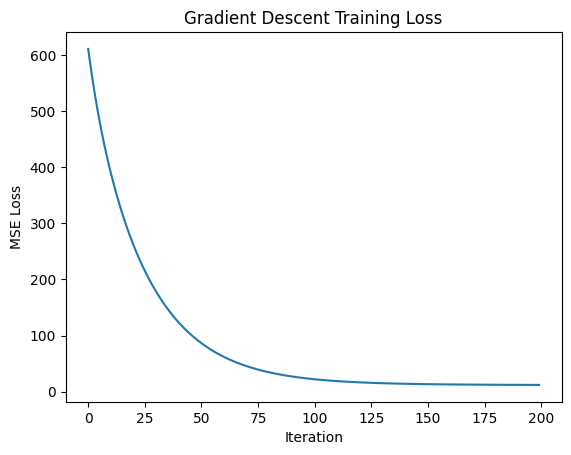

In [40]:
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

data = pd.read_csv(z.open("auto-mpg.data"), sep=r'\s+', header=None, 
                   names=['mpg', 'cylinders', 'displacement', 'horsepower', 
                          'weight', 'acceleration', 'model_year', 'origin', 'car_name'],
                   na_values='?')

# Drop missing values
data = data.dropna()

# Prepare features and target
X = data.drop(['mpg', 'car_name'], axis=1)
Y = np.array(data['mpg'], dtype=np.float64)

# One-hot encode 'origin'
X = np.array(pd.get_dummies(X, columns=['origin'], drop_first=True), dtype=np.float64)

# Standardize features (zero mean, unit variance)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0
X = (X - X_mean) / X_std

# Train using Gradient Descent
reg = LinearRegression(learning_rate=0.01, n_iterations=200)
reg.fit(X, Y)

print("Linear Regression:")
print("MSE:", reg.mean_squared_error(X, Y))
print("R2:", reg.r2_score(X, Y))
print("Final Training Loss:", reg.losses[-1])

# Plot training loss
plt.plot(reg.losses)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Gradient Descent Training Loss")
plt.show()

## Task 3.1.2 - Polynomial Regression

Transform features into polynomial terms (x, x², x³) to fit non-linear relationships.

* Implement a feature transformation step before feeding to your linear model. **(RESULT)**
* Compare the performance of the polynomial regression model (degree 2 and 3) with the linear model on the [AUTO MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) dataset. **(RESULT)**


In [43]:
from itertools import combinations_with_replacement

class PolynomialFeatures:
    """
    Transform features into polynomial features.
    
    For degree=2 and features [x1, x2]:
    Output: [1, x1, x2, x1², x1*x2, x2²]
    """
    def __init__(self, degree=2):
        self.degree = degree
        
    # I don't really understand why two different functions are needed here and what steps should be done in which exactly.
    # Can you please make your exercises more clear!
    def fit(self, X):
        """Determine the combinations of feature indices (powers) to produce."""
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("X must be 2D array-like")
        n_features = X.shape[1]
        powers = []
        # include bias (degree 0)
        for deg in range(0, self.degree + 1):
            for comb in combinations_with_replacement(range(n_features), deg):
                powers.append(tuple(comb))
        self.powers_ = powers
        self.n_input_features_ = n_features
        self.n_output_features_ = len(powers)
        return self
    
    def transform(self, X):
        """Transform X to polynomial features using fitted powers."""
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("X must be 2D array-like")
        if not hasattr(self, "powers_"):
            raise ValueError("PolynomialFeatures not fitted. Call fit or fit_transform first.")
        n = X.shape[0]
        out = np.empty((n, self.n_output_features_), dtype=np.float64)
        for j, power in enumerate(self.powers_):
            if len(power) == 0:
                # bias term
                out[:, j] = 1.0
            else:
                # product of the selected columns
                cols = X[:, list(power)]
                out[:, j] = np.prod(cols, axis=1)

        # Standardize features (as above)
        X_mean = out.mean(axis=0)
        X_std = out.std(axis=0)
        X_std[X_std == 0] = 1.0
        out = (out - X_mean) / X_std

        return out
    
    def fit_transform(self, X):
        """Fit and transform in one step."""
        self.fit(X)
        return self.transform(X)


class PolynomialRegression:
    """Polynomial Regression using Linear Regression with polynomial feature transformation."""
    def __init__(self, degree=2, learning_rate=0.01, n_iterations=1000):
        self.degree = degree
        self.poly_features = PolynomialFeatures(degree=degree)
        self.linear_model = LinearRegression(
            learning_rate=learning_rate, 
            n_iterations=n_iterations
        )
        
    def fit(self, X, y):
        """Fit polynomial regression model."""
        X = self.poly_features.fit_transform(X)
        self.linear_model.fit(X, y)
    
    def predict(self, X):
        """Make predictions on new data."""
        return self.linear_model.predict(self.poly_features.transform(X))
    
    def mean_squared_error(self, X, Y):
        X = self.poly_features.fit_transform(X)
        return self.linear_model.mean_squared_error(X, Y)

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
    def r2_score(self, X, Y):
        X = self.poly_features.fit_transform(X)
        return self.linear_model.r2_score(X, Y)

Linear Regression:
MSE: 11.99781056012773
R2: 0.8025465792408667
Final Training Loss: 12.00809503000374

Polynomial Regression (deg 2)
MSE: 7.100267643626591
R2: 0.8831476686922671
Final Training Loss: 7.112223029058641

Polynomial Regression (deg 3)
MSE: 5.627333581003483
R2: 0.9073884139315789
Final Training Loss: 5.637587737846926

Higher degrees improve performance:


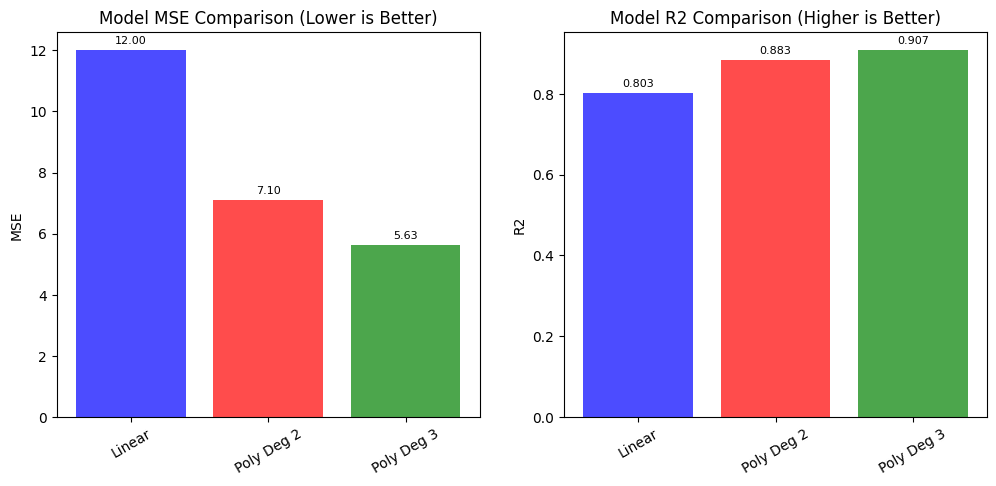

Gradient descend doesn't seem to go faster with polynomial features:


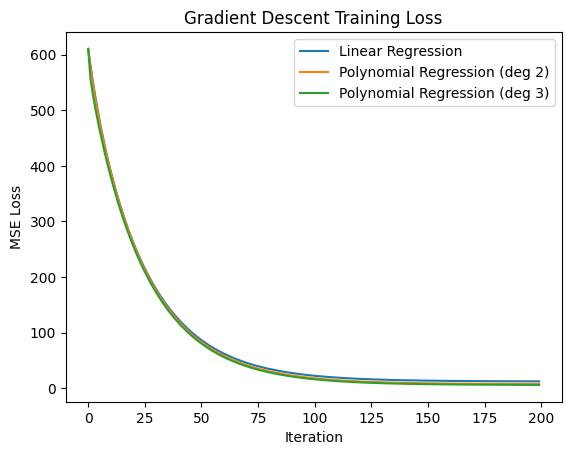

In [59]:
# Compare polynomial regression with linear regression

learning_rate=0.01
n_iterations=200

# linear regression
reg = LinearRegression(learning_rate, n_iterations)
reg.fit(X, Y)

print("Linear Regression:")
print("MSE:", reg.mean_squared_error(X, Y))
print("R2:", reg.r2_score(X, Y))
print("Final Training Loss:", reg.losses[-1])
print()

# polynomial regression
poly_reg = PolynomialRegression(degree=2, learning_rate=learning_rate, n_iterations=n_iterations)
poly_reg.fit(X, Y)

label = f"Polynomial Regression (deg {poly_reg.degree})"
print(label)
print("MSE:", poly_reg.mean_squared_error(X, Y))
print("R2:", poly_reg.r2_score(X, Y))
print("Final Training Loss:", poly_reg.linear_model.losses[-1])
print()

poly_reg3 = PolynomialRegression(degree=3, learning_rate=learning_rate, n_iterations=n_iterations)
poly_reg3.fit(X, Y)

label3 = f"Polynomial Regression (deg {poly_reg3.degree})"
print(label3)
print("MSE:", poly_reg3.mean_squared_error(X, Y))
print("R2:", poly_reg3.r2_score(X, Y))
print("Final Training Loss:", poly_reg3.linear_model.losses[-1])
print()

# Plots for MSE and R2
models = ['Linear', 'Poly Deg 2', 'Poly Deg 3']
mses = [reg.mean_squared_error(X, Y), poly_reg.mean_squared_error(X, Y), poly_reg3.mean_squared_error(X, Y)]
r2s = [reg.r2_score(X, Y), poly_reg.r2_score(X, Y), poly_reg3.r2_score(X, Y)]

x = np.arange(len(models))
fig, (ax_mse, ax_r2) = plt.subplots(1, 2, figsize=(12, 5))

print("Higher degrees improve performance:")

# MSE plot
bars1 = ax_mse.bar(x, mses, color=['b', 'r', 'g'], alpha=0.7)
ax_mse.set_xticks(x)
ax_mse.set_xticklabels(models, rotation=30)
ax_mse.set_ylabel('MSE')
ax_mse.set_title('Model MSE Comparison (Lower is Better)')
for bar in bars1:
    h = bar.get_height()
    ax_mse.annotate(f'{h:.2f}', xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

# R2 plot
bars2 = ax_r2.bar(x, r2s, color=['b', 'r', 'g'], alpha=0.7)
ax_r2.set_xticks(x)
ax_r2.set_xticklabels(models, rotation=30)
ax_r2.set_ylabel('R2')
ax_r2.set_title('Model R2 Comparison (Higher is Better)')
for bar in bars2:
    h = bar.get_height()
    ax_r2.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width() / 2, h),
                   xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

plt.show()

# Plot training loss
print("Gradient descend doesn't seem to go faster with polynomial features:")
plt.plot(reg.losses, label="Linear Regression")
plt.plot(poly_reg.linear_model.losses, label=label)
plt.plot(poly_reg3.linear_model.losses, label=label3)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Gradient Descent Training Loss")
plt.legend()
plt.show()


## Congratz, you made it! :)